# Ego4d

- Data schema at : https://ego4d-data.org/docs/data/annotations-schemas/
- some schemas does not show up well

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ann_data = json.load(open("../data/ego4d/v2/annotations/nlq_train.json"))
fho_sta_data = json.load(open("../data/ego4d/v2/annotations/fho_sta_train.json"))

In [3]:
# please see https://ego4d-data.org/docs/data/annotations-schemas/
def get_keys(d):
    keys = []
    for key, value in d.items():
        keys.append(key)
        if isinstance(value, dict):
            keys.extend(get_keys(value))
    return keys

data_keys = get_keys(fho_sta_data)
print(data_keys)

['info', 'description', 'version', 'split', 'include_annotations', 'video_metadata', '26202090-684d-4be8-b3cc-de04da827e91', 'frame_width', 'frame_height', 'fps', 'd8c894ab-7b08-4983-9e80-fdb5d6ee0202', 'frame_width', 'frame_height', 'fps', 'cde41c4f-50d1-4910-9f2a-4c7b6987df92', 'frame_width', 'frame_height', 'fps', '5b97f47f-f015-46f3-8879-3fcc2a61a728', 'frame_width', 'frame_height', 'fps', '3b609b23-f91d-43da-9918-ce928181f53f', 'frame_width', 'frame_height', 'fps', '9b316b36-7f09-450d-b397-1961723fefb7', 'frame_width', 'frame_height', 'fps', '7f9f75fd-a660-4635-8890-239c6ad82023', 'frame_width', 'frame_height', 'fps', 'c9c44dea-c37b-461d-aa14-20e934126df5', 'frame_width', 'frame_height', 'fps', '9239bf0f-db8c-4378-866d-15f302da08b5', 'frame_width', 'frame_height', 'fps', '6efe176a-ad32-4142-9785-14921ffbda23', 'frame_width', 'frame_height', 'fps', 'fe4ee880-6cae-4f62-9d4b-fda767dda6bf', 'frame_width', 'frame_height', 'fps', '3f0aa3e8-6c8c-4eab-ad6e-00d3876768d8', 'frame_width', 'f

In [4]:
# please see https://ego4d-data.org/docs/data/annotations-schemas/

anns = []
for vid in ann_data["videos"]:
    for clip in vid["clips"]:
        for ann in clip["annotations"]:
            for query in ann["language_queries"]:
                anns.append({
                    "query_start_time_sec": clip["video_start_sec"],
                    "query_end_time_sec": clip["video_end_sec"],
                    "query_response_start_time_sec": query["video_start_sec"],
                    "query_response_end_time_sec": query["video_end_sec"],
                    "query_template": query.get("template", None),
                    "query": query.get("query", None),
                })

In [5]:
num_queries = len(anns)
relative_query_sizes = np.array([
    (a["query_response_end_time_sec"] - a["query_response_start_time_sec"]) / (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])
query_sizes = np.array([
    (a["query_response_end_time_sec"] - a["query_response_start_time_sec"])
    for a in anns
])
clip_sizes = np.array([
    (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])

In [6]:
query_sizes.max(), query_sizes.min(), query_sizes.std()

(480.0, 0.13333000000000084, 23.622978784331774)

In [18]:
# less than or equal to 4 frames => 9% of training data
(query_sizes <= 4/30).sum() / len(relative_query_sizes)

np.float64(7.220737959419453e-05)

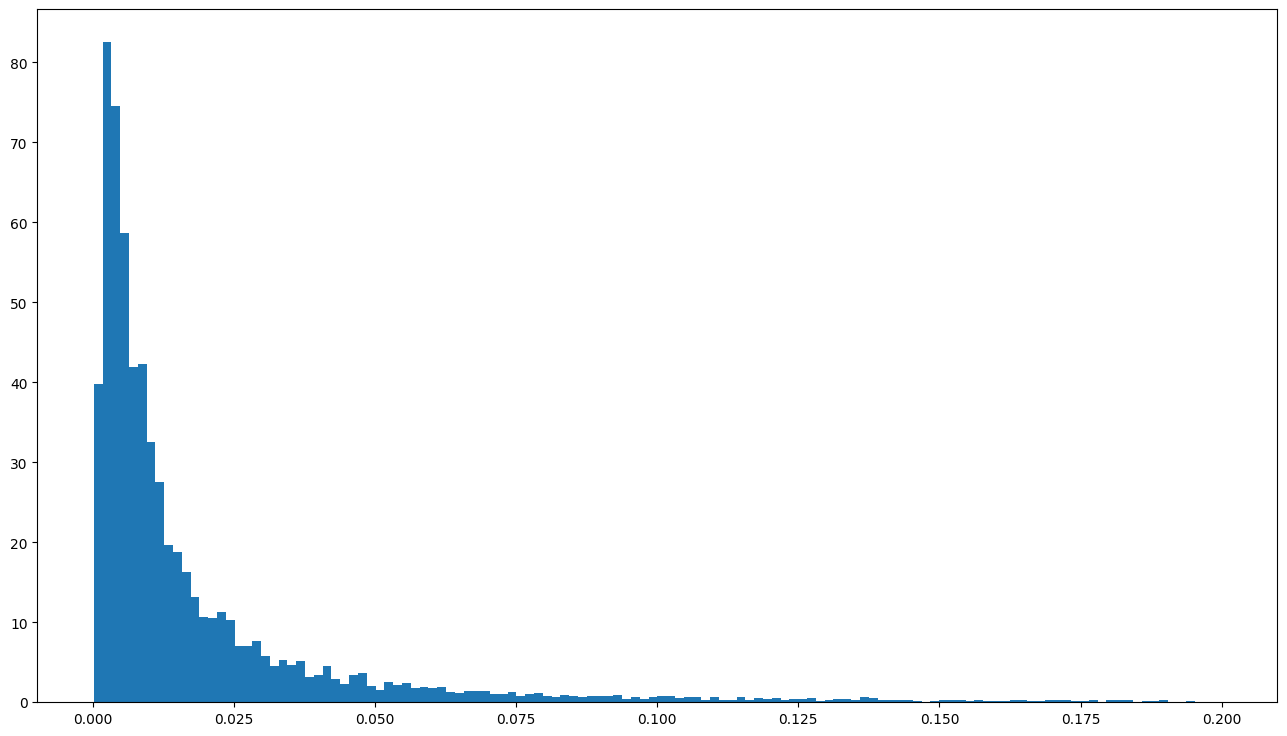

In [19]:
plt.rcParams["figure.figsize"] = (16, 9)
plt.hist(relative_query_sizes[relative_query_sizes < 0.2], density=True, bins=128)
plt.show()

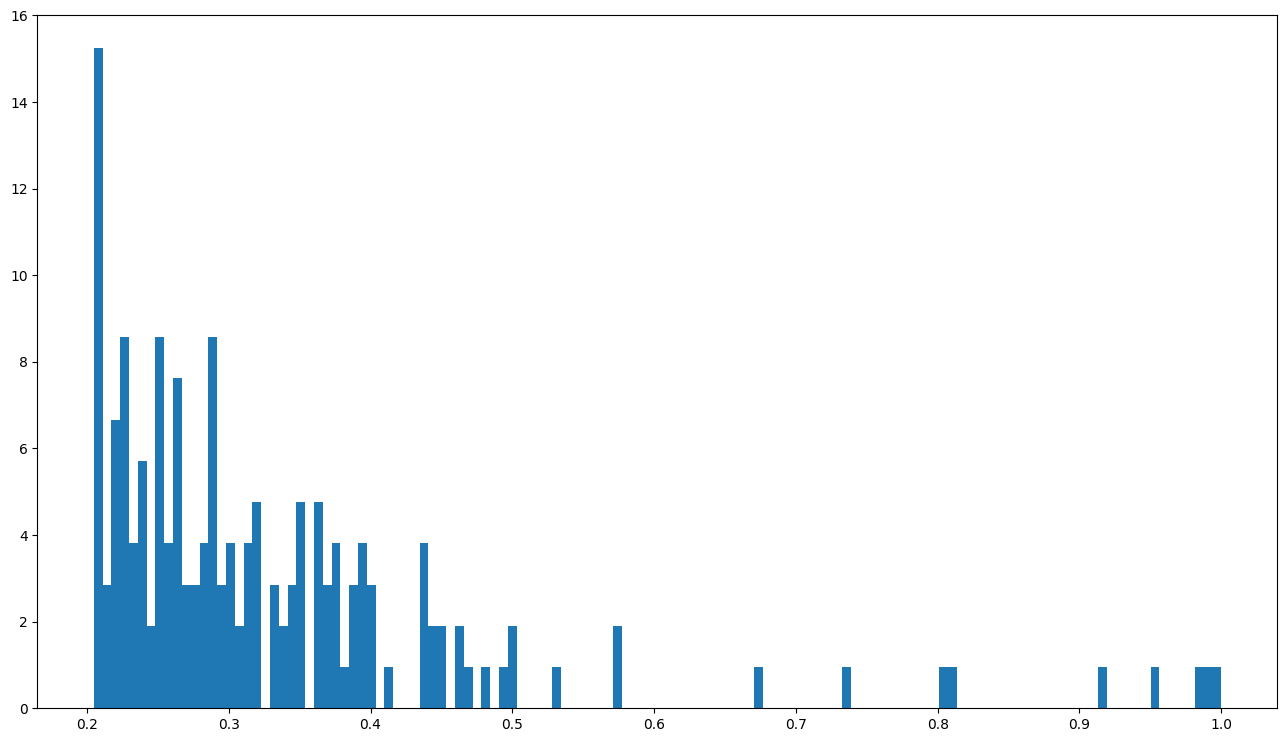

In [20]:
plt.hist(relative_query_sizes[relative_query_sizes > 0.2], density=True, bins=128)
plt.show()

In [21]:
clip_sizes.mean(), clip_sizes.max(), clip_sizes.min(), clip_sizes.std(), np.median(clip_sizes)

(np.float64(529.4506893553271),
 np.float64(1200.1333333333332),
 np.float64(207.16666666666674),
 np.float64(206.1545925371941),
 np.float64(480.0))

# Visualize the Ego4D dataset

In [22]:
import os
CLI_OUTPUT_DIR = "../data/ego4d"
VERSION = "v2"
MANIFEST_PATH = os.path.join(CLI_OUTPUT_DIR, VERSION, "manifest.csv")
print(MANIFEST_PATH)

assert os.path.exists(MANIFEST_PATH), f"Manifest doesn't exist at {MANIFEST_PATH}. Is the CLI_OUTPUT_DIR right? Do you satisfy the pre-requisites?"

../data/ego4d/v2/manifest.csv


In [24]:
# Setup
import sys
if os.path.abspath(".") not in sys.path: # Allow us to use util files in the same dir
    sys.path.insert(0, os.path.abspath("."))

import av
import collections
import csv
import cv2
import functools
import json
import logging
import math
import matplotlib.collections as mc
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd
import random
import uuid
import warnings

from celluloid import Camera
from IPython.display import HTML
from iopath.common.file_io import PathManager
from itertools import groupby
from pprint import pprint
from nb_video_utils import _get_frames # find in ego4d project as script


%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"

pathmgr = PathManager()

warnings.filterwarnings('ignore')

def vid_df_des(df):
    return f"#{len(df)} {df.duration_sec.sum()/60/60:.1f}h"
def vid_des(videos):
    return f"#{len(videos)} {sum((x.duration_sec for x in videos))/60/60:.1f}h"
def deserialize_str_list(list_: str):
    list_ = list_[1:-2]
    items = list_.split("', '")
    return list(map(lambda z: z.strip("'"), items))
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

# Video API

In [29]:
videos_df = pd.read_csv(MANIFEST_PATH)
# print(videos_df.columns)
# print(videos_df['scenarios'])
videos_df['scenarios'] = videos_df['scenarios'].apply(deserialize_str_list)
def get_video(video_uid):
    return videos_df.loc[videos_df['video_uid'] == '353ae622-c322-443e-95b4-e9927dedfa1c'].iloc[0]
print(f"R1 Videos: {vid_df_des(videos_df)}")

0       ['jobs related to construction/renovation comp...
1                                        ['Car mechanic']
2               ['Washing the dog / pet, grooming horse']
3                                  ['Cleaning / laundry']
4                                        ['Car mechanic']
                              ...                        
9816                                     ['Car mechanic']
9817    ['jobs related to construction/renovation comp...
9818    ['jobs related to construction/renovation comp...
9819        ['Crafting/knitting/sewing/drawing/painting']
9820    ['Carpenter', 'Fixing something in the home', ...
Name: scenarios, Length: 9821, dtype: object
R1 Videos: #9821 3983.4h


# Visualization Utils

In [30]:
# in: video_path, frame_number, boxes: [{ object_type, bbox: {x, y, width, height} }]}, draw_labels
# out: path to image of bboxes rendered onto the video frame
def render_frame_with_bboxes(video_path, frame_number, boxes, draw_labels = True):
    colormap = { # Custom colors for FHO annotations
        'object_of_change': (0, 255, 255),
        'left_hand': (0, 0, 255),
        'right_hand': (0, 255, 0)
    }
    defaultColor = (255, 255, 0)
    rect_thickness = 5
    rectLineType = cv2.LINE_4
    fontColor = (0, 0, 0)
    fontFace = cv2.FONT_HERSHEY_DUPLEX
    fontScale = 1
    fontThickness = 1
    with av.open(video_path) as input_video:
        frames = list(_get_frames([frame_number], input_video, include_audio=False, audio_buffer_frames=0))
        assert len(frames) == 1
        img = frames[0].to_ndarray(format="bgr24")
        for box in boxes:
            label, bbox = box['object_type'], box['bbox']
            rectColor = colormap.get(label, defaultColor) if label else defaultColor
            x, y, width, height = list(map(lambda x: int(x), [bbox['x'], bbox['y'], bbox['width'], bbox['height']]))
            cv2.rectangle(img, pt1=(x,y), pt2=(x+width, y+height), color=rectColor, thickness=rect_thickness, lineType=rectLineType)
            if label and draw_labels:
                textSize, baseline = cv2.getTextSize(label, fontFace, fontScale, fontThickness)
                textWidth, textHeight = textSize
                cv2.rectangle(img, pt1=(x - rect_thickness//2, y - rect_thickness//2), pt2=(x + textWidth + 10 + rect_thickness, y - textHeight - 10 - rect_thickness), color=rectColor, thickness=-1)
                cv2.putText(img, text=label, org=(x + 10, y - 10), fontFace=fontFace, fontScale=fontScale, color=fontColor, thickness=fontThickness, lineType=cv2.LINE_AA)
    path = f"/tmp/{frame_number}_{str(uuid.uuid1())}.jpg"
    cv2.imwrite(path, img)
    return path

# in: video_path, frames: [{ frame_number, frame_type, boxes: [{ object_type, bbox: {x, y, width, height} }] }]
# out: void; as a side-effect, renders frames from the video with matplotlib
def plot_frames_with_bboxes(video_path, frames, max_cols = 3):
    cols = min(max_cols, len(frames))
    rows = math.ceil(len(frames) / cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10*cols, 7 * rows))
    if len(frames) > 1:
        [axi.set_axis_off() for axi in axes.ravel()] # Hide axes
    for idx, frame_data in enumerate(frames):
        row = idx // max_cols
        col = idx % max_cols
        frame_path = render_frame_with_bboxes(video_path, frame_data['frame_number'], frame_data['boxes'])
        axes[row, col].title.set_text(frame_data['frame_type'])
        axes[row, col].imshow(mpimg.imread(frame_path, format='jpeg'))
    plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()
    
# in: video_path, frames: [{ frame_number, frame_label, ?boxes: [{ label, bbox: {x, y, width, height }}] }]
# out: matplotlib.ArtistAnimation of frames rendered with bounding boxes (if provided)
def render_frames_animation(video_path, frames, **kwargs):
    fig, ax = plt.subplots(figsize=(15, 9))
    camera = Camera(fig)
    for frame in frames:
        boxes = frame.get('boxes', [])
        frame_path = render_frame_with_bboxes(video_path, frame['frame_number'], boxes)
        ax.text(0, 1.01, frame['frame_label'], fontsize=20.0, transform=ax.transAxes)
        plt.imshow(mpimg.imread(frame_path, format='jpeg'))
        camera.snap()
    plt.close(fig)
    return camera.animate(**kwargs)

# in: segments: [{<start_key>: int, <end_key>: int}]
# out: void; as a side effect, renders a plot showing all segments passed in
def plot_segments(segments, start_key, end_key):
    ordered_segs = sorted(segments, key=lambda x: x[start_key])
    lines = [[(x[start_key], i), (x[end_key], i)] for i, x in enumerate(ordered_segs)]

    lc = mc.LineCollection(lines, linewidths=2)
    fig, ax = plt.subplots(figsize=(30, 10))
    ax.add_collection(lc)
    ax.autoscale()
    ax.set_xlabel('Frame', fontsize=15)
    ax.set_ylabel('Segment', fontsize=15)
    start, end = ax.get_xlim()
    stepsize = (end-start)/30
    ax.xaxis.set_ticks(np.arange(start, end, stepsize))
    plt.show()
    
# in: track: [ [{<start_key>: int, <end_key>: int, <label>: str}] ]
# out: void; as a side effect, renders a plot showing segments of each track passed in
def plot_multitrack_segments(tracks, start_key, end_key, label_key):
    cmap = plt.cm.get_cmap('tab20')
    color_palette = [cmap(x) for x in range(0, 20)]
    
    lines, colors, patches = [], [], []
    for i, segments in enumerate(tracks):
        lines += [[(x[start_key], i), (x[end_key], i)] for x in segments]
        color = color_palette[i % len(color_palette)]
        colors += [color for _ in segments]
        patches += [mpatches.Patch(color=color, label=segments[0][label_key])]

    lc = mc.LineCollection(lines, colors = colors, linewidths=550/len(tracks))
    fig, ax = plt.subplots(figsize=(30, 10))
    ax.legend(handles=patches, loc='upper left')
    ax.add_collection(lc)
    ax.autoscale()
    ax.set_xlabel('Frame', fontsize=15)
    ax.set_ylabel('Track', fontsize=15)
    start, end = ax.get_xlim()
    stepsize = (end-start)/30
    ax.xaxis.set_ticks(np.arange(start, end, stepsize))
    plt.show()

***

# Forecasting Hands and Objects (FHO)
A **video** has one or more **intervals** which contain **actions** made up of **frames** which define **bounding boxes**.

[Data Overview](https://ego4d-data.org/docs/benchmarks/hands-and-objects/)


Need to download separately?

In [32]:
# Load FHO
# with pathmgr.open(os.path.join(CLI_OUTPUT_DIR, VERSION, 'annotations', 'fho.json'), "r") as f:
with pathmgr.open(os.path.join(CLI_OUTPUT_DIR, VERSION, 'annotations', 'fho_main.json'), "r") as f:
    fho_annotations = json.load(f)
    fho_ann_video_uids = list(fho_annotations['video_data'].keys())
print(f"FHO: {len(fho_ann_video_uids)} videos - top level: {fho_annotations.keys()}")

KeyError: 'video_data'

In [33]:
# Sample one video
fho_video_uid = random.sample(fho_ann_video_uids, 1)[0]
fho_video = videos_df[videos_df.video_uid == fho_video_uid].iloc[0]
print(f"Sampled Video: {fho_video}")

NameError: name 'fho_ann_video_uids' is not defined